<a href="https://colab.research.google.com/github/estevaosmith/Portifolio/blob/main/Cluster_HMH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 2.9 MB/s eta 0:00:00


Digite o período para análise:
Data inicial (YYYY-MM-DD): 2020-01-01
Data final (YYYY-MM-DD): 2020-12-31


<ipython-input-3-7ea32a6127b0>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=transition_counts.index, x=transition_counts.values, palette="viridis")


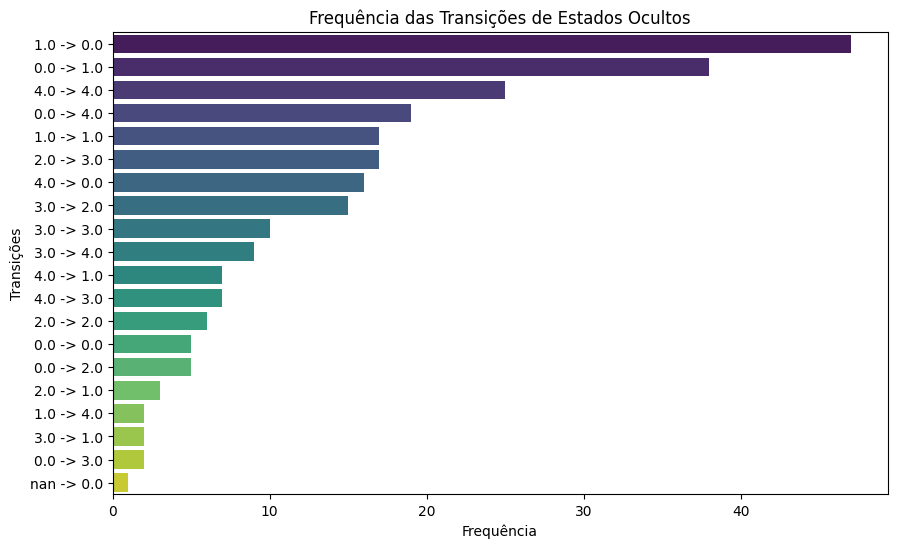

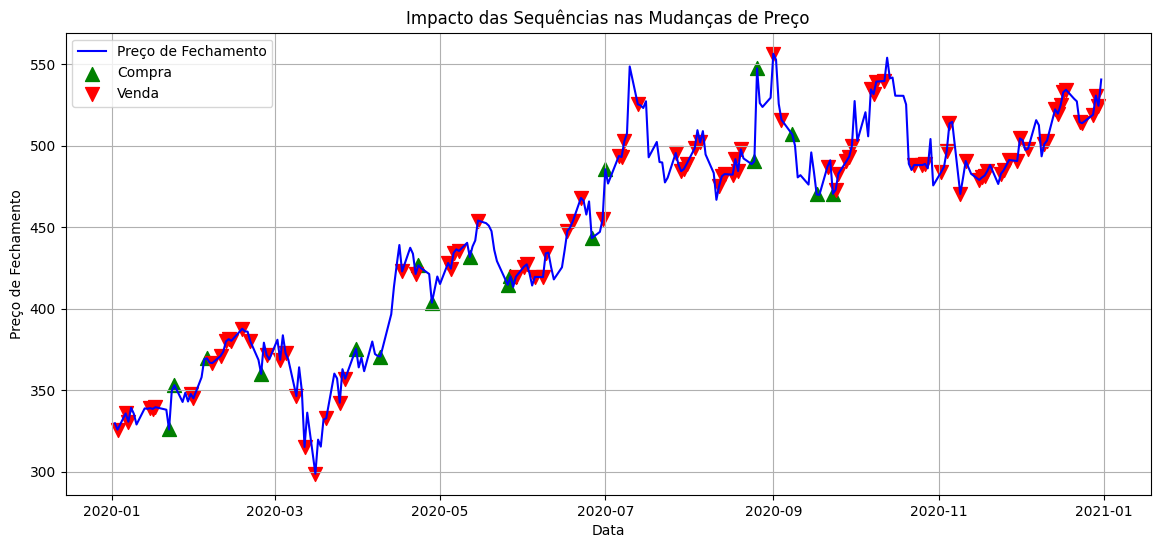


Decisões de Compra/Venda:
          Date       Close State_Transition Decision
358 2020-12-31  540.729980       nan -> 0.0   Manter
359 2020-12-30  524.590027       0.0 -> 1.0    Venda
360 2020-12-29  530.869995       1.0 -> 0.0    Venda
361 2020-12-28  519.119995       0.0 -> 1.0    Venda
362 2020-12-24  513.969971       1.0 -> 0.0    Venda
..         ...         ...              ...      ...
606 2020-01-08  339.260010       4.0 -> 0.0   Manter
607 2020-01-07  330.750000       0.0 -> 1.0    Venda
608 2020-01-06  335.829987       1.0 -> 0.0    Venda
609 2020-01-03  325.899994       0.0 -> 1.0    Venda
610 2020-01-02  329.809998       1.0 -> 1.0   Manter

[253 rows x 4 columns]


In [ ]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Carregar Dados ====
file_path = '/content/drive/MyDrive/Colab Notebooks/DATA H/Challenge 3_NFLX.xlsx'
df = pd.read_excel(file_path)

# Verificar se a coluna 'Date' existe; caso contrário, adicioná-la
if 'Date' not in df.columns:
    df['Date'] = pd.date_range(start='2024-01-01', periods=len(df), freq='D')

# ==== Permitir Input para o Período de Análise ====
print("Digite o período para análise:")
start_date = input("Data inicial (YYYY-MM-DD): ")
end_date = input("Data final (YYYY-MM-DD): ")

# Converter as datas para o formato correto
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# ==== Calcular Atributos ====
df['Body_Percent'] = (df['Close'] - df['Open']) / df['Open'] * 100
df['Volatility'] = (df['High'] - df['Low']) / df['Open'] * 100

# ==== Normalizar ====
def normalize_column(column):
    mean_value = column.mean()
    std_dev = column.std()
    return (column - mean_value) / std_dev

df['Body_Percent_Norm'] = normalize_column(df['Body_Percent'])
df['Volatility_Norm'] = normalize_column(df['Volatility'])

# ==== Implementar HMM ====
# Sequência de clusters (observáveis)
sequences = df[['Body_Percent_Norm', 'Volatility_Norm']].dropna().values

# Configurar o HMM com mais estados ocultos (n_components)
n_states = 5  # Alterar conforme necessário
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=300, random_state=42)
model.fit(sequences)

# Inferir os estados ocultos
hidden_states = model.predict(sequences)

# Adicionar os estados ocultos ao DataFrame
df['Hidden_State'] = np.nan
df.loc[~df[['Body_Percent_Norm', 'Volatility_Norm']].isnull().any(axis=1), 'Hidden_State'] = hidden_states

# ==== Estratégia de Compra e Venda ====
df['Previous_State'] = df['Hidden_State'].shift(1)
df['State_Transition'] = df['Previous_State'].astype(str) + ' -> ' + df['Hidden_State'].astype(str)

# Mapeamento expandido de decisões
expanded_decision_map = {
    (1, 4): "Compra",
    (3, 4): "Compra",
    (2, 4): "Compra",
    (4, 3): "Compra",
    (1, 0): "Venda",
    (3, 2): "Venda",
    (0, 1): "Venda",
}

# Aplicar novas decisões
df['Decision'] = df.apply(
    lambda row: expanded_decision_map.get((row['Previous_State'], row['Hidden_State']), "Manter"),
    axis=1
)

# ==== Visualizações ====
# Frequência das transições
transition_counts = df['State_Transition'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=transition_counts.index, x=transition_counts.values, palette="viridis")
plt.title("Frequência das Transições de Estados Ocultos")
plt.xlabel("Frequência")
plt.ylabel("Transições")
plt.show()

# Gráfico de Preço com Sinalização de Compra e Venda
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento', color='blue')
buy_signals = df[df['Decision'] == 'Compra']
sell_signals = df[df['Decision'] == 'Venda']

# Adicionar pontos de compra
plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Compra', marker='^', color='green', s=100)

# Adicionar pontos de venda
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Venda', marker='v', color='red', s=100)

plt.title("Impacto das Sequências nas Mudanças de Preço")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar decisões
print("\nDecisões de Compra/Venda:")
print(df[['Date', 'Close', 'State_Transition', 'Decision']].dropna())
